# The HFM library - A fast marching solver with adaptive stencils

## Part : Isotropic and anisotropic metrics
## Chapter : Classical isotropic fast marching

This notebook shows how the HFM library can solve *isotropic* eikonal equations and extract the related minimal paths. The assumption of *isotropy* makes this task rather simple and classical, and more complex models are addressed in the subsequent notebooks. We present some two and three dimensional test cases,  featuring obstacles, position and eventually time-dependent velocities, various stopping criteria, ...

The functionality presented in this notebook, in the context of isotropic fast marching, is also applicable to the more complex anisotropic models implemented in the HFM software.

[**Summary**](Summary.ipynb) of volume Fast Marching Methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Description of the problem](#1.-Description-of-the-problem)
  * [2. Calling the solver](#2.-Calling-the-solver)
  * [3. Displaying the results.](#3.-Displaying-the-results.)
  * [4. Introducing obstacles, and position dependent speed](#4.-Introducing-obstacles,-and-position-dependent-speed)
  * [5. Termination criteria](#5.-Termination-criteria)
    * [5.1 Stop when one or all of a set of points are reached by the front.](#5.1-Stop-when-one-or-all-of-a-set-of-points-are-reached-by-the-front.)
    * [5.2 Stop at a prescribed distance from the seeds](#5.2-Stop-at-a-prescribed-distance-from-the-seeds)
  * [6. Side products of the fast marching algorithm](#6.-Side-products-of-the-fast-marching-algorithm)
    * [6.1 Voronoi region computation](#6.1-Voronoi-region-computation)
    * [6.2 Euclidean length of geodesics](#6.2-Euclidean-length-of-geodesics)
  * [7. Using a time dependent speed function](#7.-Using-a-time-dependent-speed-function)
  * [8. Three dimensional fast marching](#8.-Three-dimensional-fast-marching)
  * [9. A variant : diagonal metrics](#9.-A-variant-:-diagonal-metrics)



This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries.

<!---In this series of notebooks, input and output to the HamiltonFastMarching library is based on files written on the disk. This particularly simple to install, but a bit ugly and not much scalable. Alternatively direct link based on PyBind11 is also available, as discussed in the [summary](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/HFM_Python_Notebooks/master/Summary.ipynb).--->

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Isotropic','FMM'))

In [2]:
from agd import HFMUtils
from agd.Plotting import savefig; #savefig.dirName = 'Figures/Isotropic'

In [3]:
# We will also need some standard python libraries.
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
# Required for 3D plotting
from mpl_toolkits.mplot3d import Axes3D # Plots geodesics
useMayavi = False
if useMayavi:
    from mayavi import mlab # Plots implicit surfaces

## 1. Description of the problem

In this document, we solve the standard isotropic eikonal equation, on domain denoted $\Omega$. A cost function $c : \Omega \to ]0,\infty[$ and some boundary data $\sigma : \partial \Omega \to ]-\infty,\infty]$ are given. This partial differential equation (PDE) reads
\begin{align}
\forall x \in \Omega, \|\nabla u(x)\| &= c(x), &
\forall x \in \partial \Omega, u(x) &= \sigma(x). 
\end{align}

This PDE admits a unique *viscosity* solution to this PDE, defined as follows.
The solution value $u(x)$ is minimal length (plus initial value penalization) of a path $\gamma : [0,1] \to \overline \Omega$ from the domain boundary $\partial \Omega$ to $x$.
\begin{equation*}
    u(x) = \inf_{\gamma(1)=x} \sigma(\gamma(0)) + \int_0^1 c(\gamma(t)) \|\gamma'(t)\| \, \mathrm d t.
\end{equation*}
Equivalently, the solution $u$ can be regarded as the arrival time at $x \in \Omega$ of a front originating from $\partial \Omega$ at time $\sigma : \partial \Omega \to ]-\infty,\infty]$, and propagating at speed $s = 1/c$ where $c : \Omega \to ]0,\infty[$.

In [5]:
# Create a dictionary to store the input data
hfmInput = {}

In [6]:
hfmInput.update({
    'model':'Isotropic2', # Isotropic two-dimensional eikonal equation
    'order':2., # Use a second order scheme, so as to increase accuracy
    'cost':1. # Unit cost for now. A position dependent cost function is also considered below.
    #'speed':1. # One may equivalently provide a speed function. In that case cost = 1/speed.
})

The above 'model', defined as 'Isotropic2', also determines the nature of the enclosing domain, that we denote $\Omega_0$.
It is a two dimensional box, with outflow boundary conditions on $\partial \Omega_0$. (As opposed to e.g. periodic.)

We will use the rectangle $[-1,1] \times [0,1]$, discretized on a $2n \times n$ grid where $n=100$.

In [7]:
hfmInput.update(
    HFMUtils.Rect(sides=[[-1,1],[0,1]],gridScale=0.01)
)

For the eikonal equation to be well posed, we introduce at set $S$ of 'seeds' in the domain, to which we attach initial values $(\sigma_s)_{s\in S}$. The PDE domain $\Omega\subset \Omega_0$ its boundary $\partial \Omega$, and the boundary conditions $\sigma : \partial \Omega \to ]-\infty,\infty]$ are thus as follows.

\begin{align}
\Omega &= \Omega_0 \setminus S, &
\partial \Omega &= \partial \Omega_0 \cup S, &
\sigma(x) = 
\begin{cases}
\sigma_x & \text{ if } x \in S\\
+\infty & \text{ if } x \in \partial \Omega_0.
\end{cases}
\end{align}


In [8]:
hfmInput.update({
    # Introduce two seeds, at positions (-0.5,0.3) and (0.5,0.8)
    'seeds':[[-0.5,0.3],[0.5,0.8]],
    # Boundary conditions imposed at the seeds. 
    'seedValues':[0.,0.5],
    # 'seedValues' defaults [0.,0.] if unspecified. 
})

The HFM software rounds the seed positions to the closest point of the discretization grid. To obtain the multi-index of one or several points in the discretization grid, which is useful for e.g. accessing the corresponding value in an multi-dimensional numpy array, use the pointToIndex field. Conversely, multi-indices can be converted to points.

In [9]:
hfmInput['pointToIndex'] = hfmInput['seeds'] # Request the multi-indices of these points (our seeds)
hfmInput['indexToPoint'] = [ [5,10], [20,15], [50,30] ] # Request the points associated to these indices

## 2. Calling the solver

One last step, before running the Fast-Marching solver, is to indicate which outputs are desired.
Here we request:
* The PDE solution. 
* The geodesic flow direction, computed from the numerical scheme's upwind gradients.

In [10]:
hfmInput['exportValues']=1. # Ask for the PDE solution
hfmInput['exportGeodesicFlow']=1 # Ask for the geodesic flow 

We also request three backtracked geodesics, from tips that we specify. 
In contrast with the seeds, defined above, the geodesic tips are not rounded to a point of the discretization grid.

The HFM software implements two geodesic backtracking techniques, which usually produce similar results, and are referred to as 'ODE' (integration of the geodesicFlow using the Euler midpoint scheme), and 'Discrete' (based on automatic differentiation). For details see the [paper](#mirebeau_ipol_2018).

In [11]:
hfmInput['tips'] = [[0.,0.6],[-0.9,0.5],[0.8,0.8]] # Ask for the geodesics from these three points
#hfmInput['geodesicSolver']='ODE' # Choose the backtracking method. Defaults to 'Discrete' if unspecified.

IMPORTANT : For compatibility with pyplot.contourf, numpy.meshgrid, mayavi library, ... we adopt here the convention of transposing the first two indices of the arrays. This is done by appropriately setting the "arrayOrdering" field.

In [12]:
hfmInput['arrayOrdering']='YXZ_RowMajor'
hfmInput['dummyKey']='dummyValue' # For demonstration purposes, we also add a dummy, useless input key

In [13]:
hfmOutput = HFMUtils.Run(hfmInput)

Field verbosity defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.006721 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportActiveOffsets defaults to 0


Unused keys are frequently mispelled fields. That is why they are shown with a warning.
Defaulted inputs might also be of interest, as well as the list of outputs.

In [14]:
print("Unused input keys : ", hfmOutput['unusedFromUser'],"\n") 
print("Defaulted input keys : ", hfmOutput['defaulted'],"\n") 
print("Output keys : ", hfmOutput.keys(),"\n")

Unused input keys :  dummyKey  

Defaulted input keys :  exportActiveNeighs exportActiveOffsets factoringMethod geodesicSolver geodesicStep geodesicVolumeBound geodesicWeightThreshold refineStencilAtWallBoundary showProgress spreadSeeds verbosity  

Output keys :  dict_keys(['FMCPUTime', 'GeodesicCPUTime', 'MaxStencilWidth', 'StencilCPUTime', 'defaulted', 'geodesicFlow', 'geodesicLengths', 'geodesicPoints', 'indexFromPoint', 'nAccepted', 'pointFromIndex', 'unusedFromCompute', 'unusedFromUser', 'values', 'visitedUnset']) 



In [15]:
hfmInput.pop('dummyKey',None)

'dummyValue'

The output field indexFromPoint contains the multi-indices, for use in e.g. the array of solution values, associated with the physical pour coordinates set in the input field pointToIndex.

In our case, pointToIndex was set to the two seed positions $x_0,x_1$, to which were attached the boundary conditions $\sigma(x_0)=0$ and $\sigma(x_1)=0.5$. Let us check that the boundary condition $u(x_1)=\sigma(x_1)=0.5$ at the seed $x_1=(0.5,0.8)$ is indeed satisfied.

In [16]:
index = hfmOutput['indexFromPoint'][1,:].astype(int) # This is the index of seed number 1, that we requested above.
print(hfmOutput['values'][index[1],index[0]] ) # Note the YXZ convention.

0.5


Similarly, the output field pointFromIndex contains the physical coordinates, in the domain $\Omega$, of the multi-indices specified in the input field indexToPoint.

In [17]:
hfmOutput['pointFromIndex'] # Points associated with the multi-indices provided in the indexToPoint input field

array([[-0.945,  0.105],
       [-0.795,  0.155],
       [-0.495,  0.305]])

## 3. Displaying the results.

The level lines of the computed distance map can be displayed using the contourf function. 

In [18]:
X,Y = HFMUtils.GetGrid(hfmInput) # Create a coordinate system

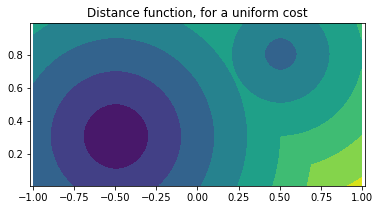

In [19]:
plt.figure(figsize=[6,3]); plt.title('Distance function, for a uniform cost'); plt.axis('equal');
plt.contourf(X,Y,hfmOutput['values']); # Display the value function. 

The geodesics, three in our case, are returned as a list of points, and a list of lengths. 
The following line splits them into separate arrays, for more convenient manipulation. We then plot.

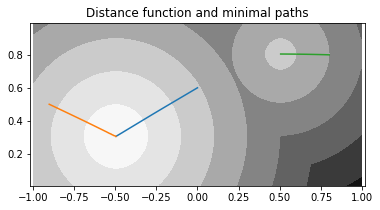

In [20]:
fig = plt.figure(figsize=[6,3]); plt.title('Distance function and minimal paths'); plt.axis('equal'); 

# Draw the geodesics
for geo in HFMUtils.GetGeodesics(hfmOutput): plt.plot(geo[:,0],geo[:,1]) 

# Overlay the contour plot of the distance map
plt.contourf(X,Y,hfmOutput['values'],cmap='Greys');
savefig(fig,'Dist_Path_UnifCost.png')

The minimal geodesics associated with our path planning problem obey an Ordinary Differential Equation (ODE), defined in terms of the solution $u$ of the eikonal PDE. 
More precisely, the minimal geodesic reaching the point $x \in \Omega$ at the time $T = u(x)$ obeys 
\begin{align*}
    \forall t \leq T, \gamma'(t) &= V(\gamma(t)), &
    \gamma(T) &= x.
\end{align*}
In practice, this ODE is solved *backwards in time*, as evidenced by terminal boundary condition $\gamma(T) = x$..

The vector field $V : \Omega \to {\mathbb R}^2$, displayed in the next cell, is referred to as the geodesic flow direction, and is expressed in terms of the gradient of the arrival times function $u : \Omega \to \mathbb R$. In the case of an isotropic metric, defined by a cost function $c: \Omega \to ]0,\infty[$
\begin{equation*}
    V(x) = c(x)^{-2} \nabla u(x),
\end{equation*}


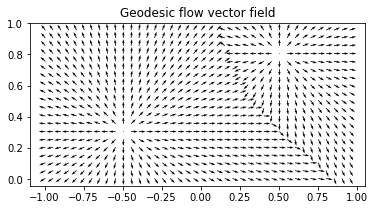

In [21]:
fig = plt.figure(figsize=[6,3]); plt.title('Geodesic flow vector field'); plt.axis('equal'); 

flowX, flowY = hfmOutput['geodesicFlow'][:,:,0], hfmOutput['geodesicFlow'][:,:,1]

# Quiver plot of the geodesic flow. We subsample by a factor 5, using subscript [::5,::5], for better visualisation.
plt.quiver(X[::5,::5],Y[::5,::5],flowX[::5,::5],flowY[::5,::5]);
savefig(fig,'GeodesicFlow.png')

By construction, the geodesic flow has unit speed, as measured by the metric of the problem. In the present case of an isotropic metric, this is easily checked formally, since we get for each point $x \in \Omega$
\begin{equation*}
c(x) \|V(x)\| = c(x)^{-1} \| \nabla u(x)\| = 1.
\end{equation*}
Note that this identity is not satisfied at the two seed points, which strictly speaking are part of $\partial \Omega$. We check this identity numerically in the next cell.

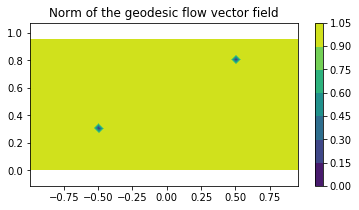

In [22]:
fig = plt.figure(figsize=[6,3]); plt.title('Norm of the geodesic flow vector field'); plt.axis('equal'); 

norms = hfmInput['cost']*np.sqrt(flowX**2+flowY**2)
myplot = plt.contourf(X[::5,::5],Y[::5,::5],norms[::5,::5])
plt.colorbar();
savefig(fig,'GeodesicFlowNorm.png')

In [24]:
hfmInput['exportGeodesicFlow']=0. # Do not export the geodesic flow in further experiments.

## 4. Introducing obstacles, and position dependent speed

A obstacle is described as an array of 0 (obstacle absent) or 1 (obstacle present).
One-pixel-thin structures can be used to represent walls. In the case, considered in the following notebooks, where adaptive wide stencil discretization schemes are used, a test is done to ensure that the scheme offsets do not jump over the walls.

Outflow boundary conditions, $\sigma(x) = \infty$, are applied at each point $x$ of the obstacles.

In [25]:
# Let us construct a round shaped obstacle, and 1-pixel wide a barrier
disk = (X-0.3)**2 + (Y-0.3)**2 <= 0.2**2
barrier = np.logical_and(X==X[0,70], Y>=0.4)
obstacle = np.logical_or(disk,barrier)
hfmInput['walls']=obstacle # Add the obstacle to the input parameters. 

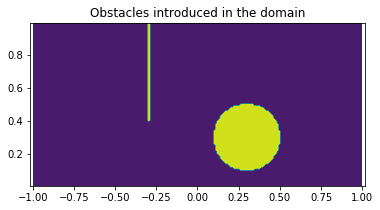

In [26]:
fig = plt.figure(figsize=[6,3]); plt.title('Obstacles introduced in the domain'); plt.axis('equal'); 
plt.contourf(X,Y,obstacle);
savefig(fig,'Obstacles.png')

We next consider a position dependent cost function. Recall the eikonal equation
\begin{align*}
\forall x \in \Omega, \,  \|\nabla u(x)\| &= c(x) &
\forall x \in \partial \Omega, \, u(x) = \sigma(x).
\end{align*}

In [27]:
hfmInput['cost'] = np.exp(-0.5*(X**2+Y**2))

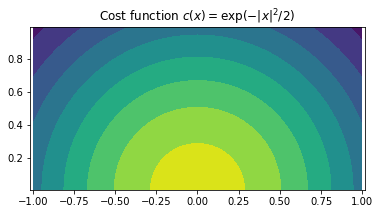

In [28]:
fig = plt.figure(figsize=[6,3]); plt.title('Cost function $c(x)=\exp(-\|x\|^2/2)$'); plt.axis('equal'); 
plt.contourf(X,Y,hfmInput['cost']);
savefig(fig,'CostFunction.png')

In [29]:
hfmOutput =HFMUtils.Run(hfmInput)

Field verbosity defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.007317 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportActiveOffsets defaults to 0


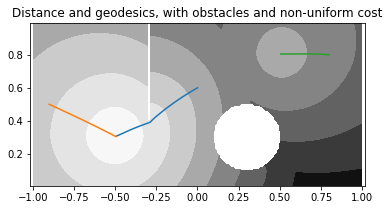

In [30]:
fig = plt.figure(figsize=[6,3]); plt.title('Distance and geodesics, with obstacles and non-uniform cost'); plt.axis('equal'); 
plt.contourf(X,Y,hfmOutput['values'],cmap='Greys') # Display the value function. 
for geo in HFMUtils.GetGeodesics(hfmOutput):  plt.plot(geo[:,0],geo[:,1]) 
savefig(fig,'Dist_Paths_CostObstacles.png')

## 5. Termination criteria

The HFM software by default terminates when eikonal PDE is solved on the entire domain $\Omega$, by propagating a front in a single pass, in a Dijkstra-like manner. However it can be interesting to abort the computation early, in order for instance to save CPU time. Various stopping criteria are available for that purpose.

### 5.1 Stop when one or all of a set of points are reached by the front.

We provide an option for stopping the front propagation as soon as *every* member of a collection of points is reached.
In many applications, the minimal geodesics are more valuable than the distance map itself. In that case, one may stop the front propagation as soon as all the geodesic tips are reached. Computation time is reduced, and geodesic backtracking is still feasible. 

In [31]:
hfmInput['stopWhenAllAccepted']=hfmInput['tips'] # Abort computation when all the tips are reached by the front

In [32]:
hfmOutput = HFMUtils.Run(hfmInput)

Field verbosity defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.005986 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportActiveOffsets defaults to 0


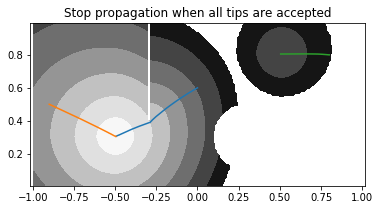

In [33]:
fig = plt.figure(figsize=[6,3]); plt.title('Stop propagation when all tips are accepted'); plt.axis('equal'); 
plt.contourf(X,Y,hfmOutput['values'],cmap='Greys');  # Display the value function. 
for geo in HFMUtils.GetGeodesics(hfmOutput):  plt.plot(geo[:,0],geo[:,1]) 
savefig(fig,'StopAllTipsAccepted.png')

A second option stops the front propagation as soon as *any* member of a collection of points is reached. For illustration, we stop as soon as the first geodesic tip is reached. The geodesic originating from this particular point can be backtraced, but obviously the others cannot anymore.

In [34]:
hfmInput['stopWhenAnyAccepted']=hfmInput['tips']

In [35]:
hfmOutput = HFMUtils.Run(hfmInput)

Field verbosity defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.002683 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportActiveOffsets defaults to 0


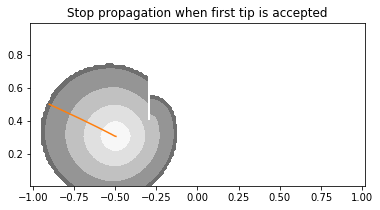

In [36]:
plt.figure(figsize=[6,3]); plt.title('Stop propagation when first tip is accepted'); plt.axis('equal'); 
plt.contourf(X,Y,hfmOutput['values'],cmap='Greys');   # Display the value function.  
for geo in HFMUtils.GetGeodesics(hfmOutput):  plt.plot(geo[:,0],geo[:,1]) 

In [37]:
# We won't use these stopping criteria anymore.
hfmInput.pop('stopWhenAllAccepted',None);
hfmInput.pop('stopWhenAnyAccepted',None);

### 5.2 Stop at a prescribed distance from the seeds

We here decide to terminate the front propagation once the value function, i.e. the distance from the seeds (plus possibly the boundary condition), reaches a provided threshold.

In [38]:
hfmInput['stopAtDistance']=0.7

In [39]:
hfmOutput = HFMUtils.Run(hfmInput)

Field verbosity defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.007312 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportActiveOffsets defaults to 0


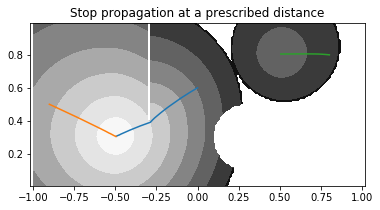

In [39]:
plt.figure(figsize=[6,3]); plt.title('Stop propagation at a prescribed distance'); plt.axis('equal'); 
plt.contourf(X,Y,hfmOutput['values'],cmap='Greys'); # Display the value function.  
for geo in HFMUtils.GetGeodesics(hfmOutput):  plt.plot(geo[:,0],geo[:,1]) 

In [40]:
hfmInput.pop('stopAtDistance',None); # We won't use this stopping criterion anymore

## 6. Side products of the fast marching algorithm

The HFM software can compute several side products in addition to the (approximate) distance map $u : \Omega \to ]-\infty,\infty]$. In this section, we present two of them: the euclidean length of the minimal geodesics, and the Voronoi diagram associated with the seeds. Since these computations are performed simultaneously with the front propagation, they are also used within stopping criteria.

### 6.1 Voronoi region computation

The Voronoi cell of a seed consists of all the points which are closer to this seed than to the others.

In [41]:
hfmInput['seedFlags']=np.array([0,1]) # Define voronoi region indices associated with the seeds.

In [42]:
hfmOutput = HFMUtils.Run(hfmInput)

Field verbosity defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field voronoiStoppingCriterion defaults to None
Field factoringMethod defaults to None
Fast marching solver completed in 0.006739 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.0001
Field geodesicVolumeBound defaults to 4.225
Field exportActiveNeighs defaults to 0
Field exportVoronoiFlags defaults to 1


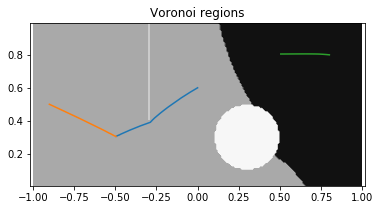

In [43]:
fig = plt.figure(figsize=[6,3]); plt.title('Voronoi regions'); plt.axis('equal'); 
plt.contourf(X,Y,hfmOutput['voronoiFlags'],cmap='Greys'); # Display the Voronoi regions.
for geo in HFMUtils.GetGeodesics(hfmOutput):  plt.plot(geo[:,0],geo[:,1]) 
savefig(fig,'VoronoiRegions.png')

In next experiment, we terminate the computation as soon as the two Voronoi regions $V_0,V_1$ *meet*. More precisely, as soon as they contain points $x_0,x_1$ that differ by a single unit at a single coordinate
\begin{equation*}
    x_1-x_0 \in \{(0,\pm 1), (\pm 1,0)\}.
\end{equation*}
We also display the geodesics backtraced from $x_0$ and $x_1$. By construction, they can be concatenated into a single minimal geodesic joining the two seeds.

In [44]:
hfmInput['voronoiStoppingCriterion']='RegionsMeeting'

In [45]:
hfmOutput = HFMUtils.Run(hfmInput)

Field verbosity defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.005575 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.0001
Field geodesicVolumeBound defaults to 4.225
Field exportActiveNeighs defaults to 0
Field exportVoronoiFlags defaults to 1
Field voronoiDiagram_exportGeodesicFromMeetingPoint defaults to 1


In [46]:
print("The Voronoi regions meet at the neighbor points x0 =",hfmOutput['voronoiDiagram_meetingPoint0'],
      "and x1 =", hfmOutput['voronoiDiagram_meetingPoint1'])

The Voronoi regions meet at the neighbor points x0 = [0.225 0.725] and x1 = [0.215 0.725]


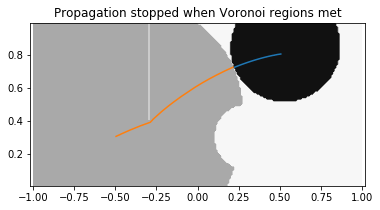

In [47]:
fig = plt.figure(figsize=[6,3]); plt.title('Propagation stopped when Voronoi regions met'); plt.axis('equal'); 
plt.contourf(X,Y,hfmOutput['voronoiFlags'],cmap='Greys');  # Display the Voronoi regions.
for geo in HFMUtils.GetGeodesics(hfmOutput,'voronoiDiagram'):  plt.plot(geo[:,0],geo[:,1]) 

In [48]:
hfmInput.pop('voronoiStoppingCriterion',None); # We won't use this stopping criterion anymore.

### 6.2 Euclidean length of geodesics

A simple addition to the numerical scheme allows to compute the euclidean length of the minimal geodesics from the seeds towards the points of the fast marching front. Optionally, we may to interrupt the computations once these lengths reach a prescribed threshold.

The scale of the grid must be specified in each direction. Optionally, this scale may vary over the domain.

In [49]:
gridScale=hfmInput['gridScale']
hfmInput['euclideanScale']=[gridScale,gridScale] # euclidean scale of the grid in the x and y directions 
hfmInput['stopAtEuclideanLength']=1. # Optional. Stopping criterion based on euclidean length of geodesics.

In [50]:
hfmOutput = HFMUtils.Run(hfmInput)

Field verbosity defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field voronoiStoppingCriterion defaults to None
Field factoringMethod defaults to None
Fast marching solver completed in 0.007234 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.0001
Field geodesicVolumeBound defaults to 4.225
Field exportActiveNeighs defaults to 0
Field exportEuclideanLengths defaults to 1
Field euclideanLength_exportGeodesicFromStoppingPoint defaults to 1
Field exportVoronoiFlags defaults to 1


In [51]:
hfmOutput.keys()

dict_keys(['FMCPUTime', 'MaxStencilWidth', 'StencilCPUTime', 'defaulted', 'euclideanLength_stoppingPoint', 'euclideanLengths', 'geodesicLengths', 'geodesicLengths_euclideanLength', 'geodesicPoints', 'geodesicPoints_euclideanLength', 'indexFromPoint', 'nAccepted', 'pointFromIndex', 'unusedFromCompute', 'values', 'visitedUnset', 'voronoiFlags'])

In [52]:
print("Euclidean length stopping criterion was triggered at :", hfmOutput['euclideanLength_stoppingPoint'])

Euclidean length stopping criterion was triggered at : [0.445 0.145]


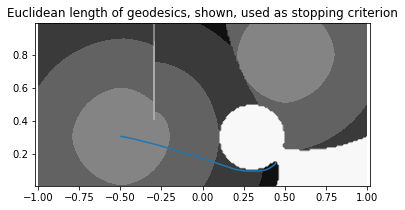

In [53]:
fig=plt.figure(figsize=[6,3]); plt.title('Euclidean length of geodesics, shown, used as stopping criterion'); plt.axis('equal'); 

plt.contourf(X,Y,hfmOutput['euclideanLengths'],cmap='Greys');  # Display the geodesic euclidean lengths.
# Display the point that triggered the stopping criterion, and the corresponding minimal geodesic
for geo in HFMUtils.GetGeodesics(hfmOutput,'euclideanLength'):  plt.plot(geo[:,0],geo[:,1]) 
savefig(fig,'EuclideanLength.png')

As a consistency check, we compare the value function with the euclidean length of geodesics, the latter being computed with an adequately chosen point dependent scale. The two quantities are equal up to machine precision, as expected, on the voronoi region of the left seed. On the voronoi region of the right seed, they differ by the seed boundary value, namely $0.5$.

In [54]:
hfmInput['euclideanScale'] = gridScale*np.stack((hfmInput['cost'],hfmInput['cost']),2)
hfmInput.pop('stopAtEuclideanLength',None)
hfmInput['order']=1 # Disable second order enhancement, so as to get an exact match of the two methods.

In [55]:
hfmOutput = HFMUtils.Run(hfmInput)

Field verbosity defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field voronoiStoppingCriterion defaults to None
Field factoringMethod defaults to None
Fast marching solver completed in 0.008111 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.0001
Field geodesicVolumeBound defaults to 4.225
Field exportActiveNeighs defaults to 0
Field exportEuclideanLengths defaults to 1
Field exportVoronoiFlags defaults to 1


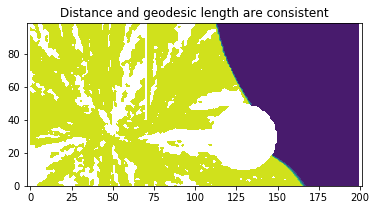

In [56]:
plt.figure(figsize=[6,3]); plt.title('Distance and geodesic length are consistent'); plt.axis('equal'); 
plt.contourf(hfmOutput['euclideanLengths']-hfmOutput['values']);

In [57]:
# Restore parameters
hfmInput['order']=2.
hfmInput.pop('euclideanScale',None);

## 7. Using a time dependent speed function

In this section, we consider a path planning problem in which the speed function depends on both position and time
\begin{equation*}
    s : \Omega \times \mathbb R \to ]0,\infty[.
\end{equation*}
The corresponding eikonal equation reads
\begin{align*}
\forall x \in \Omega, s(x,u(x)) \| \nabla u(x) \| &= 1, &
\forall x \in \partial \Omega, u(x) &= \sigma(x).
\end{align*}
Recall that the speed function is the reciprocal of the cost function, i.e. $s=1/c$. The numerical example below can trivially be adapted to the (equivalent) case of a time dependent cost function. 

In order to define a time dependent speed function, one must provide an increasing family of times $t_0<t_1< \ldots <t_K$ is provided, and a family of speed functions at these time points $s_0,s_1,\ldots, s_K : \Omega \to ]0,\infty[$.
In each time interval, the HFM software performs linear interpolation:
\begin{align*}
s(x,t) &= (1-\delta) s_k(x) + \delta s_{k+1}(x) &
\text{ if } t &= (1-\delta)t_k+\delta t_{k+1}, 
\end{align*}
for some $0 \leq k < K$, and some $\delta \in [0,1]$.
The speed function is prolongated by a constant, w.r.t. time, before $t_0$ and after $t_K$
\begin{align*}
s(x,t)&=s_0(x) \text{ if } t \leq t_0, &
s(x,t)&=s_K(x) \text{ if } t \geq t_K.
\end{align*}

In [58]:
hfmInput.pop('cost',None) # Remove the previous cost function

hfmInput['speed_times'] = [0.2,0.6,1.4] # Define the interpolation times t0,t1,t2
hfmInput['speed_0'] = np.exp(0.5*(X**2+Y**2)) # Initial speed function s0
hfmInput['speed_1'] = 0.2 # Intermediate speed function s1, defined as a small constant over the domain
hfmInput['speed_2'] = hfmInput['speed_0'] # Last speed function, chosen equal to the first one

In [59]:
hfmOutput = HFMUtils.Run(hfmInput)

Field verbosity defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field voronoiStoppingCriterion defaults to None
Field factoringMethod defaults to None
Fast marching solver completed in 0.007043 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.0001
Field geodesicVolumeBound defaults to 4.225
Field exportActiveNeighs defaults to 0
Field exportVoronoiFlags defaults to 1


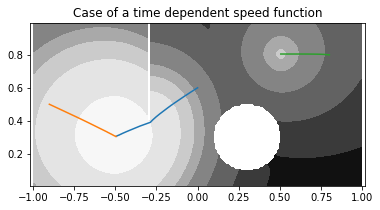

In [60]:
fig = plt.figure(figsize=[6,3]); plt.title('Case of a time dependent speed function'); plt.axis('equal'); 
plt.contourf(X,Y,hfmOutput['values'],cmap='Greys'); plt.axis('equal'); # Display the value function.  
for geo in HFMUtils.GetGeodesics(hfmOutput):  plt.plot(geo[:,0],geo[:,1]) 
savefig(fig,'TimeDependent.png')

## 8. Three dimensional fast marching

In this section, we demonstrate three dimensional isotropic fast marching. The mayavi plugin is used for 3D surface plotting. Like numpy.meshgrid, it has the convention of transposing the first two indices of the arrays.

Like numpy.meshgrid, mayavi has the convention of transposing the first two indices of the arrays.

In [61]:
# Define the domain as the block [0,3] x [0,2] x [0,1]
hfmInput3D = HFMUtils.Rect(sides=[[0,3],[0,2],[0,1]],dimx = 150)

# Meshgrid convention
hfmInput3D['arrayOrdering']='YXZ_RowMajor'
hfmInput3D['model']='Isotropic3'
X3D,Y3D,Z3D = HFMUtils.GetGrid(hfmInput3D) 

In [62]:
hfmInput3D.update({
    'order':2,
    'exportValues':1,
    # A list of seeds is required, even if the list is only 1 element long.
    'seeds':[[0.3,0.5,0.7]],
    'speed':np.exp(-(X3D-1.5)**2-(Y3D-1)**2-(Z3D-0.5)**2)
})

In [63]:
nGeo = 3
hfmInput3D['tips']=np.array([ [x,y,z]  
                 for x in HFMUtils.CenteredLinspace(0,3,nGeo)
                 for y in HFMUtils.CenteredLinspace(0,2,nGeo)
                 for z in HFMUtils.CenteredLinspace(0,1,nGeo)])

In [64]:
hfmOutput = HFMUtils.Run(hfmInput3D)

Field verbosity defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.529569 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.0001
Field geodesicVolumeBound defaults to 5.4925
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0


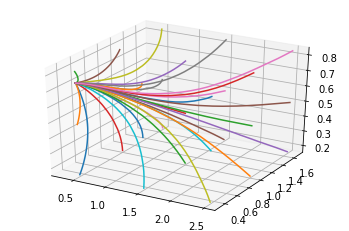

In [65]:
fig = plt.figure()
ax = fig.gca(projection='3d')
for geodesic in HFMUtils.GetGeodesics(hfmOutput):  
    ax.plot(geodesic[:,0],geodesic[:,1],geodesic[:,2])

In [66]:
if useMayavi: 
    mlab.contour3d(hfmOutput['values'], contours=[1,3,5,10])
    mlab.show() # Displays in an external window. 

This is what the previous command should display.
![Solution level set](Images/0_Isotropic_Contour3D.png)

## 9. A variant : diagonal metrics

This section is devoted to diagonal metrics, a classical, minor but often useful, generalization of the isotropic considered above.  The path cost takes the form
\begin{equation*}
   L_M(\gamma) := \int_0^1 \| \gamma'(t)\|_{M(\gamma(t))} \,\mathrm d t,
\end{equation*}
where $M(x)$ is a diagonal matrix, dependent on the current position $x \in \Omega$. Recall that $\|v\|_M = \sqrt{<M v,v>}$.
The cost can be rewritten in the form
\begin{equation*}
     \| \dot x \|_{M(x)} = \sqrt{\sum_{1 \leq i \leq d} c_i(x)^2 \dot x_i^2},
\end{equation*}
where $\dot x = (\dot x_1,\cdots, \dot x_d)$, and where the diagonal coefficients of the metric are $(c_1(x)^2,\cdots, c_d(x)^2)$. 

The user inputs $d$ cost functions $c_1,\cdots,c_d : \overline \Omega \to ]0,\infty[$, where $d$ is the dimension, instead of a single one in the isotropic case.
All the tools described in the isotropic case of course also apply to the diagonal models, as well as to the more sophisticated models described in the further notebooks.

In [67]:
# The three dimensional counterpart Diagonal3 is also implemented
hfmInput2 = {'model':'Diagonal2'}
# Distinct cost relative to the x and y directions
hfmInput2['cost'] = np.stack(( np.exp(-0.5*(X**2+Y**2)),  np.ones(X.shape)),axis=2)

# Possibly distinct gridscale as well (not used here)
h= hfmInput['gridScale'];
hfmInput2['gridScales'] = [h,h]

for key in ['walls','dims','seeds','seedValues','tips','arrayOrdering','exportValues','origin']:
    hfmInput2[key]=hfmInput[key]

In [68]:
hfmOutput = HFMUtils.Run(hfmInput2)

Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.005301 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.0001
Field geodesicVolumeBound defaults to 4.225
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0


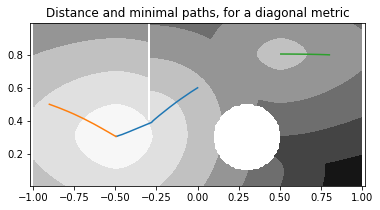

In [69]:
fig = plt.figure(figsize=[6,3]); plt.title('Distance and minimal paths, for a diagonal metric'); plt.axis('equal'); 
plt.contourf(X,Y,hfmOutput['values'],cmap='Greys') # Display the value function.  
for geo in HFMUtils.GetGeodesics(hfmOutput):  plt.plot(geo[:,0],geo[:,1]) 
savefig(fig,'Diagonal.png')